# 🧪 Exploring Zero-Shot Classification with CLIP

In this section, we explore the power of **zero-shot learning** using **OpenAI's CLIP model**.

Unlike traditional classifiers that require task-specific training, CLIP is pre-trained on a vast set of image–text pairs and can match images to relevant **text prompts** out-of-the-box.

This allows us to:

- Perform classification **without fine-tuning** on our dataset
- Compare an input image against a list of **candidate labels**
- Leverage **natural language** descriptions for more flexible predictions

We'll demonstrate how to apply CLIP to classify flower images using descriptive labels like `"daisy"`, `"sunflower"`, and `"rose"`.


## ⚙️ Setup: Install Required Libraries

Before using CLIP for zero-shot classification, we need to install the required libraries:

- **`transformers`**: Provides access to the CLIP model via Hugging Face.
- **`torch`**: PyTorch is the backend framework required for running CLIP.
- **`Pillow`**: For image loading and preprocessing.

We'll install these using `pip` in the Colab environment.


In [1]:
!pip install -q git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00


## 🧩 Import Modules and Select Compute Device

We now import the necessary libraries for working with the CLIP model:

- **`torch`** and **`torchvision`** for tensor operations and image transforms
- **`transformers`** to load the CLIP model and processor
- **`PIL`** to handle image loading
- **`matplotlib`** for visual display

We'll also check if a **GPU** is available and use it to speed up inference. If not, the model will run on CPU.


In [2]:
# Essential imports for inference and visualization
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Determine whether to use GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Computation device selected: {device}")


Computation device selected: cuda


## 🧠 Load CLIP Model

We load the **CLIP model (ViT-B/32 variant)** using Hugging Face’s `transformers` library.

- **ViT-B/32** is a vision transformer-based model that offers a strong balance between **accuracy** and **inference speed**.
- Along with the model, we load the **CLIP processor**, which handles tokenization for text and preprocessing for images.

This setup allows us to input raw text and images and obtain meaningful embeddings for zero-shot classification.


In [3]:
# Load the CLIP vision-language model along with preprocessing pipeline
model, preprocess = clip.load("ViT-B/32", device=device)
print("Successfully loaded CLIP (ViT-B/32) model.")


100%|███████████████████████████████████████| 338M/338M [00:13<00:00, 27.0MiB/s]


Successfully loaded CLIP (ViT-B/32) model.


## 🖼️ Create Test Image

To demonstrate zero-shot classification with CLIP, we’ll generate a **simple red image** using the Python Imaging Library (PIL).

This serves as a placeholder in case an **online image fails to load**, and allows us to verify that CLIP can still process and classify synthetic or abstract inputs using its vision-language understanding.


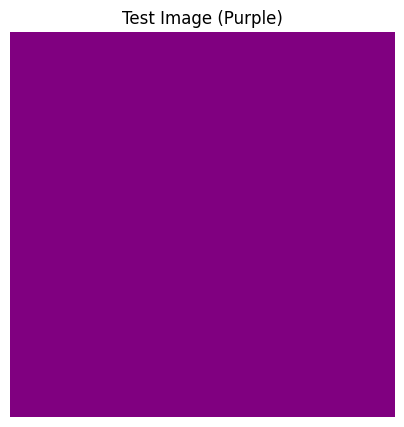

In [4]:
# Create a purple image (symbolic of grapes or creative backgrounds)
width, height = 300, 300
image = Image.new('RGB', (width, height), color='purple')

# Preprocess image for model input
image_input = preprocess(image).unsqueeze(0).to(device)

# Display the purple image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.title("Test Image (Purple)")
plt.show()

## 🧪 Perform Zero-Shot Classification

In this step, we define a list of **text labels** that describe different object categories (e.g., `"a red square"`, `"a rose"`, `"a stop sign"`).

Using CLIP’s pre-trained vision-language embeddings:

- The model encodes both the **image** and **text prompts** into a shared embedding space.
- It computes **cosine similarity** between the image and each text prompt.
- The prompt with the **highest similarity score** is selected as the predicted label.

This approach allows us to classify images **without any task-specific training**.

In [5]:
label_prompts = [
    "a purple object", "a colorful sign", "a shiny surface", "a warning label",
    "a type of fruit", "a vibrant pattern", "an artistic background", "a glossy item"
]

# Tokenize the candidate text descriptions
text_inputs = clip.tokenize(label_prompts).to(device)

# Perform zero-shot prediction using CLIP
with torch.no_grad():
    # Encode image and text into the shared embedding space
    img_features = model.encode_image(image_input)
    txt_features = model.encode_text(text_inputs)

    # Normalize vectors to compute cosine similarity
    img_features /= img_features.norm(dim=-1, keepdim=True)
    txt_features /= txt_features.norm(dim=-1, keepdim=True)

    # Calculate similarity and get top predictions
    similarity_scores = (100.0 * img_features @ txt_features.T).softmax(dim=-1)
    top_scores, top_indices = similarity_scores[0].topk(5)

# Print classification results
print("Top matching descriptions and confidence scores:")
for score, idx in zip(top_scores, top_indices):
    print(f"{label_prompts[idx]:30s}: {score.item() * 100:.1f}%")

Top matching descriptions and confidence scores:
a purple object               : 95.6%
a vibrant pattern             : 1.8%
a shiny surface               : 1.7%
an artistic background        : 0.4%
a glossy item                 : 0.3%


## 📊 Visualize Zero-Shot Results

To interpret CLIP's predictions more intuitively, we plot a **horizontal bar chart** showing the **top 5 text prompts** along with their **confidence scores**.

This helps visualize how confident the model is about its predictions and allows for easy comparison across the candidate labels.

We use `matplotlib` to generate the plot.


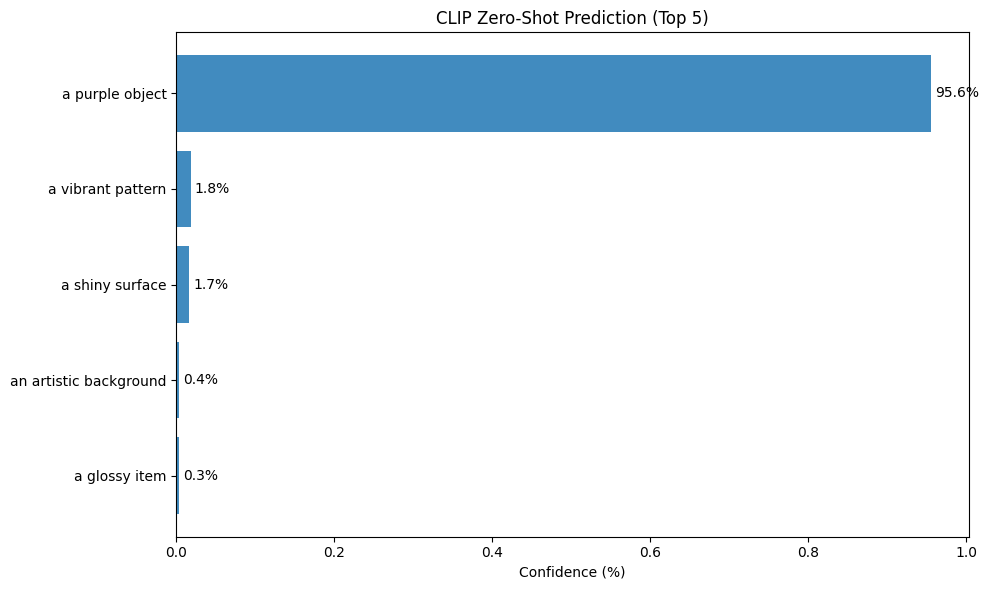

In [6]:
# Visualize top predictions from CLIP using a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define positions and bar heights
positions = np.arange(len(top_indices))
scores = [score.item() for score in top_scores]
labels = [label_prompts[i] for i in top_indices]

# Create the horizontal bar chart
ax.barh(positions, scores, align='center', alpha=0.85)
ax.set_yticks(positions)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # Highest score on top

# Axis labels and title
ax.set_xlabel('Confidence (%)')
ax.set_title('CLIP Zero-Shot Prediction (Top 5)')

# Annotate each bar with its percentage value
for i, score in enumerate(scores):
    ax.text(score + 0.005, i, f'{score * 100:.1f}%', va='center')

plt.tight_layout()
plt.show()


## 🎨 Test Zero-Shot on Multiple Colors

To further explore CLIP's zero-shot capabilities, we generate and classify **multiple solid-colored images** (e.g., red, green, blue, yellow).

This demonstrates how CLIP can:

- Generalize to **abstract visual inputs** without needing retraining
- Correctly associate **visual color cues** with **natural language labels**
- Work effectively across diverse input types — even those not resembling real-world photos

Each image will be matched against relevant text prompts like `"a green square"`, `"a blue block"`, etc., showcasing CLIP’s flexible understanding.


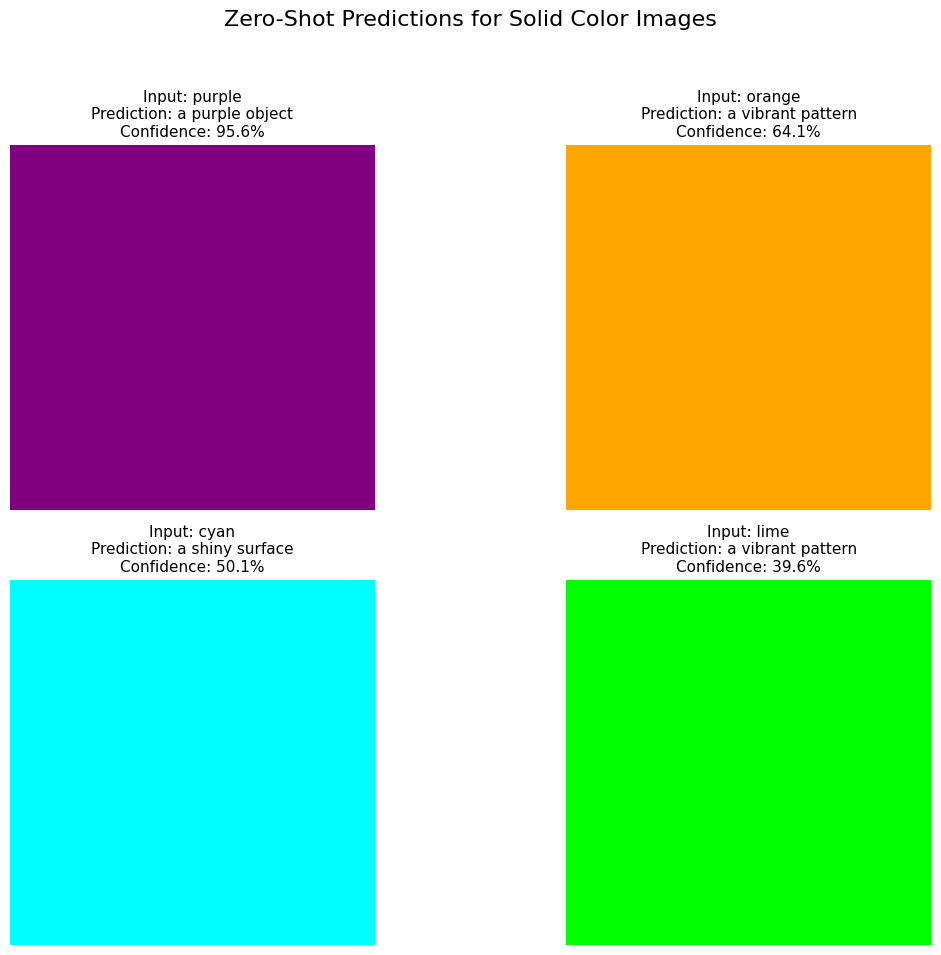

In [7]:
# Evaluate CLIP on a set of solid color images using updated layout and labels
from matplotlib.gridspec import GridSpec

test_colors = ['purple', 'orange', 'cyan', 'lime']
fig = plt.figure(figsize=(12, 10))
grid = GridSpec(2, 2, figure=fig)
axes = [fig.add_subplot(grid[i]) for i in range(4)]

for i, color in enumerate(test_colors):
    # Create a solid color image
    color_img = Image.new('RGB', (100, 100), color=color)
    input_tensor = preprocess(color_img).unsqueeze(0).to(device)

    # Run CLIP prediction
    with torch.no_grad():
        feat = model.encode_image(input_tensor)
        feat /= feat.norm(dim=-1, keepdim=True)
        sim = (100.0 * feat @ txt_features.T).softmax(dim=-1)
        score, label_idx = sim[0].topk(1)

    # Display results
    axes[i].imshow(color_img)
    axes[i].set_title(
        f'Input: {color}\nPrediction: {label_prompts[label_idx.item()]}\nConfidence: {score.item() * 100:.1f}%',
        fontsize=11
    )
    axes[i].axis('off')

plt.suptitle("Zero-Shot Predictions for Solid Color Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
